<a href="https://colab.research.google.com/github/EnoiuDiana/Stroke-Predictor/blob/bori_dev/Stroke_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction based on medical and demographical data

## Problem Statement

TODO: nice description of what we want to do, why this is relevant, etc.

## Dataset



*   [source](https://https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
*   each entry represents one person
*   label, to be predicted: whether a person is likely to have a stroke



## Setup

In [368]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [369]:
def_plot_length = 7
def_fig_size = (def_plot_length, def_plot_length)
def_title_size = 20
random_state = 42

### Data Gathering

In [370]:
file_path = "https://drive.google.com/file/d/1x3Vu2Egi5LIvd0jkHnZKeBx-Ye0l8sTr/view?usp=sharing"
file_path ='https://drive.google.com/uc?id=' + file_path.split('/')[-2]
stroke_df = pd.read_csv(file_path)

In [371]:
stroke_df = stroke_df.rename(str.lower, axis='columns')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Train-Test Split



*   **stroke_df**: dataframe used for training and validation
*   **stroke_test_df**: dataframe used for testing. Not used in the decision processer related to model training



In [372]:
X = stroke_df.drop(columns=['stroke'])
y = stroke_df.stroke

In [373]:
X_stroke_tv_df, X_stroke_test_df, y_stroke_tv_df, y_stroke_test_df = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [374]:
X_stroke_tv_df.shape

(4088, 11)

In [375]:
X_stroke_test_df.shape

(1022, 11)

In [376]:
stroke_df = pd.concat([X_stroke_tv_df, y_stroke_tv_df], axis = 1)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
845,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
3744,43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
4183,47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
3409,56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


In [377]:
stroke_test_df = pd.concat([X_stroke_test_df, y_stroke_test_df], axis = 1)

In [378]:
print("Stroke ratio in train-test dataframe: ", stroke_df[stroke_df.stroke == 1].shape[0] / stroke_df.shape[0])

Stroke ratio in train-test dataframe:  0.04867906066536203


In [379]:
print("Stroke ratio in train-test dataframe: ", stroke_test_df[stroke_test_df.stroke == 1].shape[0] / stroke_test_df.shape[0])

Stroke ratio in train-test dataframe:  0.04892367906066536


--> the train+validation and the test datasets are well balanced regarding the ratio of people who had stroke

## Initial Data Analysis

Goal: 
*   get to know our data
*   see how data should be cleaned
*   find interesting correlations
*   formulate a hypothesis

TODO: write a nice introduction before submitting the assignment :)

In [380]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,3918.000000,4088.000000
mean,36547.666585,43.353288,0.097114,0.054061,106.317167,28.922180,0.048679
std,21238.482961,22.596816,0.296148,0.226165,45.259652,7.928378,0.215223
min,77.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17621.500000,26.000000,0.000000,0.000000,77.312500,23.600000,0.000000
50%,36963.500000,45.000000,0.000000,0.000000,91.945000,28.000000,0.000000
75%,54787.750000,61.000000,0.000000,0.000000,114.197500,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Analysing the individual features

#### Helper functions

In [381]:
def plot_continuous_variable_distribution(df, var_series, var_name, title):
  sns.displot(data=df, x=var_name, kde=True, height=def_plot_length)
  # median
  disp = 0.4
  plt.axvline(x=var_series.median(),
              color='red')
  plt.text(var_series.median() + disp, 0, "50%", rotation = 90)
  # 25%
  plt.axvline(x=var_series.quantile(0.25),
              color='red')
  plt.text(var_series.quantile(0.25) + disp, 0, "25%", rotation = 90)
  # 75%
  plt.axvline(x=var_series.quantile(0.75),
              color='red')
  plt.text(var_series.quantile(0.75) + disp, 0, "75%", rotation = 90)
  # mean
  plt.axvline(x=var_series.mean(),
              color='green')
  plt.text(var_series.mean() + disp, 0, "Mean", rotation = 90)

  plt.title(title, size=def_title_size)

In [382]:
def plot_continuous_variable_stroke_ratio(df, var_name, no_quantiles, title, xticks_rotation=0, nr_bar_decimals=2, nr_tick_decimals = 2):
  stroke_df_group = stroke_df.copy()
  stroke_df_group[var_name+"_group"] = pd.qcut(stroke_df_group[var_name], q=no_quantiles)
  stroke_ratio_per_var_group = stroke_df_group.groupby([var_name+"_group"]).apply(lambda age_group: age_group["stroke"].sum() / age_group["stroke"].count())
  fig, ax = plt.subplots(figsize=def_fig_size)
  pal = sns.color_palette("rocket", len(stroke_ratio_per_var_group))
  rank = stroke_ratio_per_var_group.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

  plots = sns.barplot(x = stroke_ratio_per_var_group.index, y = stroke_ratio_per_var_group.values, ax = ax, palette = np.array(pal[::-1])[rank])
  print(type(stroke_ratio_per_var_group.index[0]))

  # Iterating over the bars one-by-one to add annotations
  for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.{0}f'.format(nr_bar_decimals)),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                    textcoords='offset points')
      
  xlabels = stroke_ratio_per_var_group.index.map(lambda interval : "({left:.{nr_dec}f}, {right:.{nr_dec}f}".format(nr_dec = nr_tick_decimals, left = interval.left, right = interval.right))
  ax.set_xticklabels(xlabels)
      
  plt.xticks(rotation=xticks_rotation)
  plt.title(title, size = def_title_size)


In [383]:
def plot_categorical_variable_stroke_ratio(df, var_name, title, nr_bar_decimals=2):
  stroke_cnt = df.groupby([var_name, 'stroke']).count()
  stroke_cnt = stroke_cnt.loc[:, :, ] .reset_index().pivot(index=var_name, columns='stroke', values='id')
  stroke_cnt['stroke_ratio'] = stroke_cnt[1] / (stroke_cnt[0] + stroke_cnt[1])

  fig, ax = plt.subplots(figsize=(10, 6))
  pal = sns.color_palette("rocket", len(stroke_cnt))
  rank = stroke_cnt['stroke_ratio'].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
  plots = sns.barplot(x = stroke_cnt.index, y = stroke_cnt['stroke_ratio'], ax = ax, palette = np.array(pal[::-1])[rank])

  # Iterating over the bars one-by-one to add annotations
  for bar in plots.patches:
      plots.annotate(format(bar.get_height(), '.{0}f'.format(nr_bar_decimals)),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')

  plt.title(title, size = def_title_size)

In [384]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [385]:
def get_mean_based_on_age(df):
  children_median = df[df['age'] < 18]['bmi'].median()
  adults_median = df[df['age'] >= 18]['bmi'].median()
  return children_median, adults_median

In [386]:
def clean_bmi(df, children_median, adults_median):
    df_plus = df.copy()
    df_plus['bmi_was_missing'] = df_plus['bmi'].isnull()
    
    df_plus['bmi'] = df_plus.apply(
        lambda row: children_median if ((np.isnan(row['bmi'])) & (row['age'] < 18)) else row['bmi'],
        axis=1
    )
    df_plus['bmi'] = df_plus.apply(
        lambda row: adults_median if ((np.isnan(row['bmi'])) & (row['age'] >= 18)) else row['bmi'],
        axis=1
    )
    return df_plus

#### Gender

First of all, we should analyze the gender types that we have in our dataset.

In [387]:
gender_value_counts = stroke_df.gender.value_counts()
gender_value_counts

Female    2395
Male      1692
Other        1
Name: gender, dtype: int64

We only have one value for other gender type, it might not help us with our prediction.

In [388]:
stroke_df.loc[stroke_df['gender']=='Other']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Having a pie chart will help us visualize better the ratio between females and males. We can observe that this ratio is not very balanced, having 59% females and only 41% male.

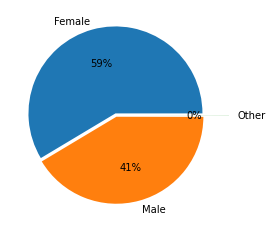

In [389]:
explode = [0.02,0.02,0.3]
plt.pie(gender_value_counts.array, labels=gender_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

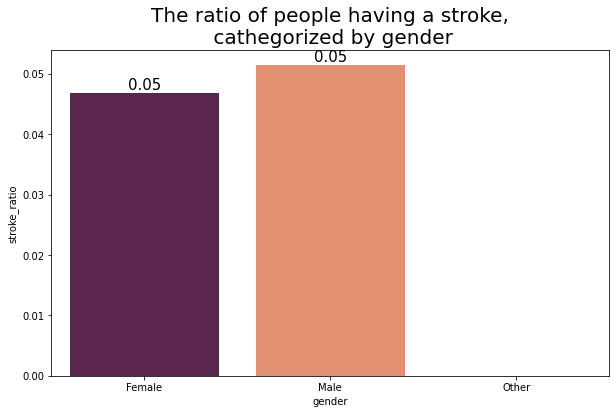

In [390]:
plot_categorical_variable_stroke_ratio(stroke_df, "gender", "The ratio of people having a stroke,\n cathegorized by gender")

The stroke events are evenly split among men and woman, but the number of men that had stroke is slightly greater than the number of woman, in our dataset. In general it is expected that stroke events are more frequently in woman, as they tend to live longer ([see article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2665267/)).

#### Age

In [391]:
stroke_df.age.describe()

count    4088.000000
mean       43.353288
std        22.596816
min         0.080000
25%        26.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64



*   **median age: 45.0**
  *   considering that the **median age in the world is only 30.63**, this dataset seems to describe an **aging population**, probably from one of the highly developed countries
  *   note that only 5 countries in he world have a median age >= 5 (Italy, Saint Pierre and Miquelon, Germany, Japan and Monaco)
  *   source: [worldpopulationreview.com](https://worldpopulationreview.com/country-rankings/median-age)



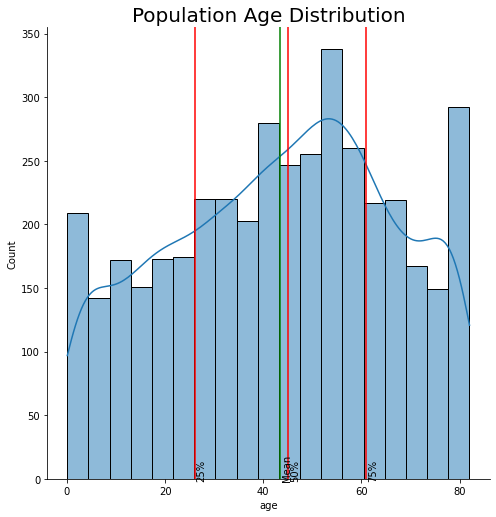

In [392]:
plot_continuous_variable_distribution(stroke_df, stroke_df.age, "age", "Population Age Distribution")

Text(0.5, 1.0, 'Age Distribution by Stroke Status')

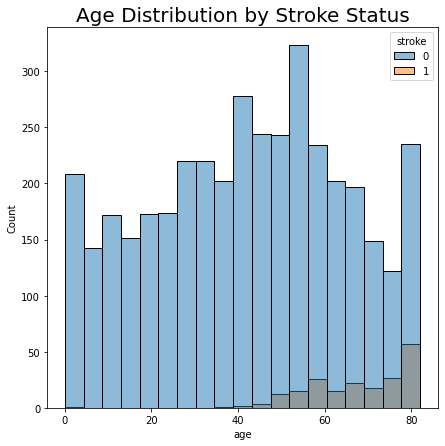

In [393]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=stroke_df, x="age", hue="stroke", ax=ax)
plt.title("Age Distribution by Stroke Status", size = def_title_size)

<class 'pandas._libs.interval.Interval'>


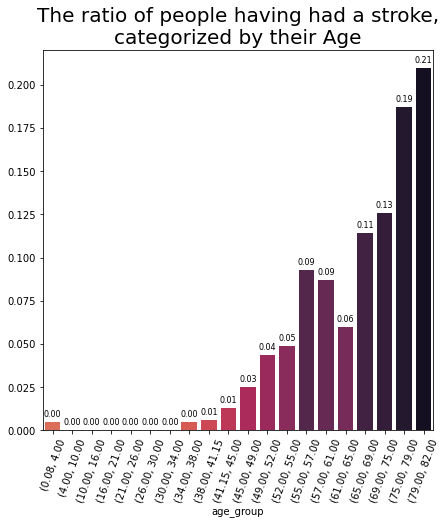

In [394]:
plot_continuous_variable_stroke_ratio(stroke_df, "age", 20, "The ratio of people having had a stroke,\ncategorized by their Age", 70)

As expected, the ratio of the population who had a stroke increases by age.

#### Hypertension

From all the persons in our dataset, we can see that only 10% have had hypertension. Globally, **an estimated 26% of the world’s population** (972 million people) has hypertension.

https://www.medscape.com/answers/241381-7614/what-is-the-global-prevalence-of-hypertension-high-blood-pressure

In [395]:
hypertension_value_counts = stroke_df.hypertension.value_counts()
hypertension_value_counts

0    3691
1     397
Name: hypertension, dtype: int64

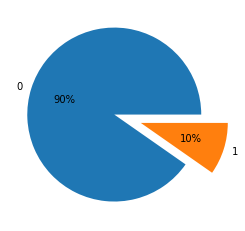

In [396]:
explode = [0.02,0.3]
plt.pie(hypertension_value_counts.array, labels=hypertension_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

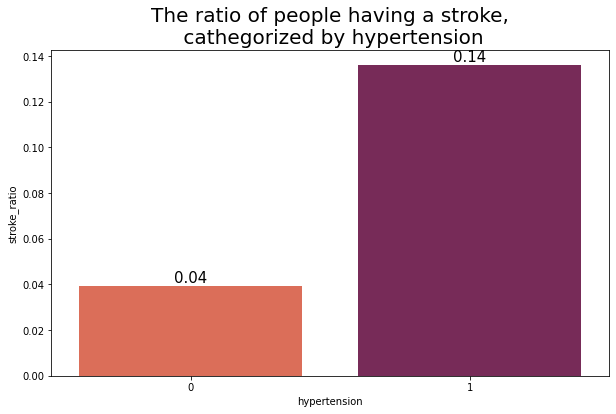

In [397]:
plot_categorical_variable_stroke_ratio(stroke_df, "hypertension", "The ratio of people having a stroke,\n cathegorized by hypertension")

As expected, a stroke is more common for people that suffer from hypertension than the rest of the people.

#### Heart Disease

The feeature shows whether a person has (1) os hasn't got (0) any herat diseases.

In [398]:
heart_disease_value_counts = stroke_df.heart_disease.value_counts()
heart_disease_value_counts

0    3867
1     221
Name: heart_disease, dtype: int64

Only 276 people out of 5110 had a heart disease.

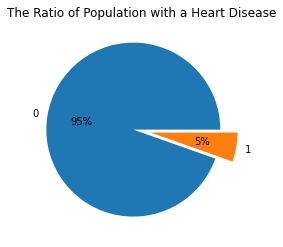

In [399]:
explode = [0.1] * heart_disease_value_counts.count()
plt.pie(heart_disease_value_counts.array, labels=heart_disease_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Ratio of Population with a Heart Disease")
plt.show()

The people with a heart disease represent 5% of the population.

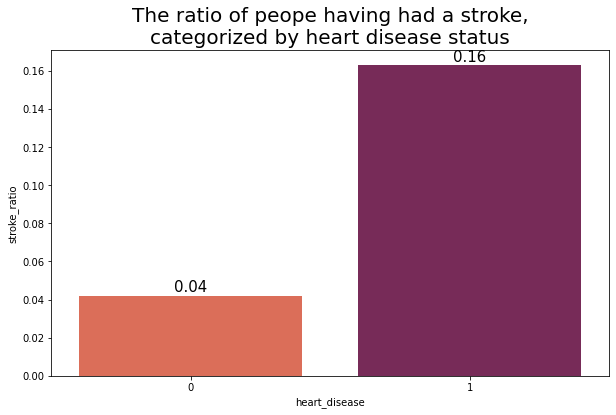

In [400]:
plot_categorical_variable_stroke_ratio(stroke_df, "heart_disease", "The ratio of peope having had a stroke,\ncategorized by heart disease status")

As expected, the ratio of people who had a stroke is much higher (17% vs 4%) among people with a heart disease.

#### Marital Status

The values for marital status are 'Yes' or 'No' values. We prefer to have 0 or 1 values instead.

In [401]:
ever_married_value_counts = stroke_df.ever_married.value_counts()
ever_married_value_counts

Yes    2700
No     1388
Name: ever_married, dtype: int64

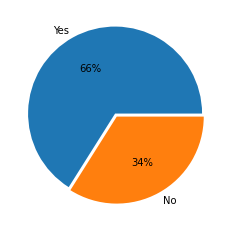

In [402]:
explode = [0.02,0.02]
plt.pie(ever_married_value_counts.array, labels=ever_married_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

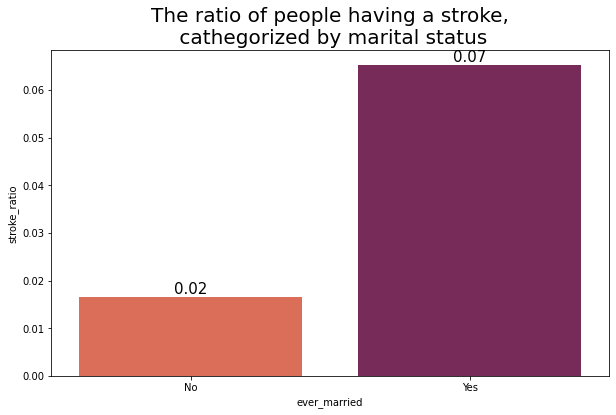

In [403]:
plot_categorical_variable_stroke_ratio(stroke_df, "ever_married", "The ratio of people having a stroke,\n cathegorized by marital status")

This plot shows that stroke is more common in people who are married, but this may be due to the fact that older people (that are at a higher risk of having a stroke) in general are married. 

#### Work Type

We have identified several work types i.e. private, self-employed, government job, children and never worked.

In [404]:
work_type_value_counts = stroke_df.work_type.value_counts()
work_type_value_counts

Private          2332
Self-employed     667
children          554
Govt_job          522
Never_worked       13
Name: work_type, dtype: int64

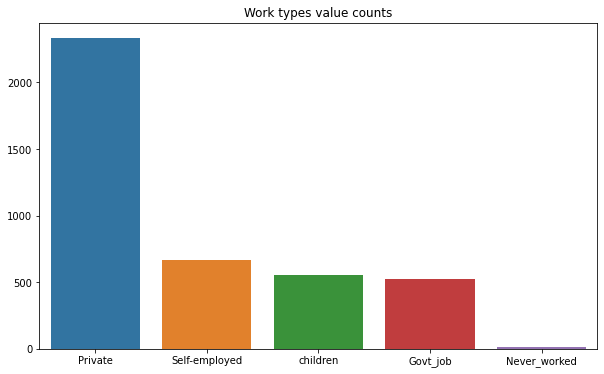

In [405]:
plt.figure(figsize=(10,6))
plt.title("Work types value counts")
sns.barplot(x=work_type_value_counts.index, y=work_type_value_counts.array)
plt.show()

The values children and never worked might be corellated since most children don't work. Let's see how many never worked values are for people with an age greater than 18.

In [406]:
stroke_df.loc[(stroke_df['work_type'] == 'Never_worked') & (stroke_df['age'] >= 18)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
4772,13960,Female,18.0,0,0,No,Never_worked,Urban,97.65,21.5,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
2917,11702,Female,18.0,0,0,No,Never_worked,Urban,82.36,22.7,Unknown,0


There are only five values for never worked people that aren't children. They also didn't have a stroke. We might consider deleting them in the data cleaning process.

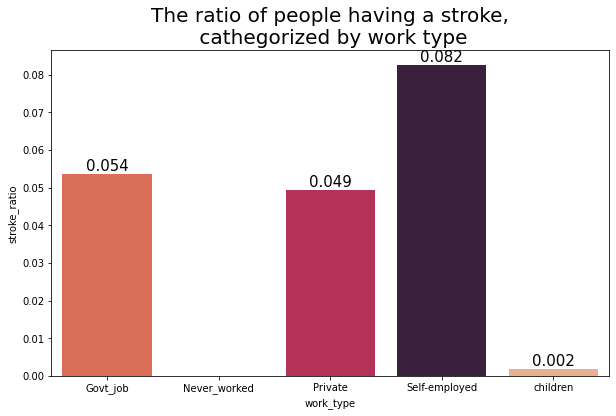

In [407]:
plot_categorical_variable_stroke_ratio(stroke_df, "work_type", "The ratio of people having a stroke,\n cathegorized by work type", 3)

We can observe that we have very few strokes among children and never_worked (which are mostly children). The stroke events are evenly split among government jobs and private work types, but self-employed people tend to have more strokes. Accordingly to this [study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7287446/), **self-employed people might have a higher risk of having a cardiovascular disease**, which might lead to a stroke, but the studies made about this subject are very limited.

#### Residence Type

The feature shows whether the person lives in a rural or urban area.

In [408]:
residence_type_value_counts = stroke_df.residence_type.value_counts()
residence_type_value_counts

Urban    2069
Rural    2019
Name: residence_type, dtype: int64

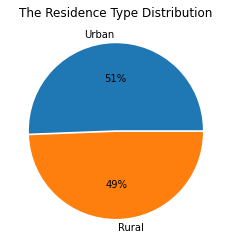

In [409]:
explode = [0.01] * residence_type_value_counts.count()
plt.pie(residence_type_value_counts.array, labels=residence_type_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Residence Type Distribution")
plt.show()

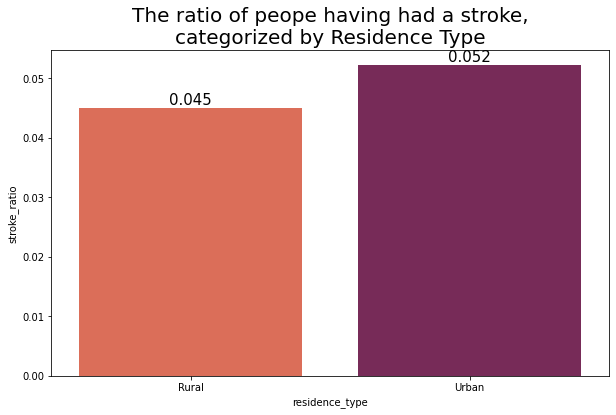

In [410]:
plot_categorical_variable_stroke_ratio(stroke_df, "residence_type", "The ratio of peope having had a stroke,\ncategorized by Residence Type", 3)

The data shows that people living in an urban area have a slightly higher chance for a stroke (5.2% vs 4.5%), but the residence type does not seem to be a significant factor in one's chance for a stroke.

The people are fairly distributed between twose living in urban and in rural areas.

#### Average Glucose Level

This feature shows the average glucose level in a person's blood, in mg/dL.

In [411]:
stroke_df.avg_glucose_level.describe()

count    4088.000000
mean      106.317167
std        45.259652
min        55.120000
25%        77.312500
50%        91.945000
75%       114.197500
max       271.740000
Name: avg_glucose_level, dtype: float64

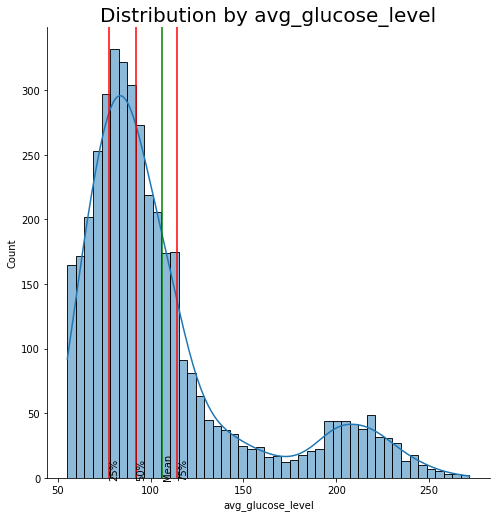

In [412]:
plot_continuous_variable_distribution(stroke_df, stroke_df.avg_glucose_level, "avg_glucose_level", "Distribution by avg_glucose_level")

Text(0.5, 1.0, 'Avg Glucose Level Distribution by Stroke Status')

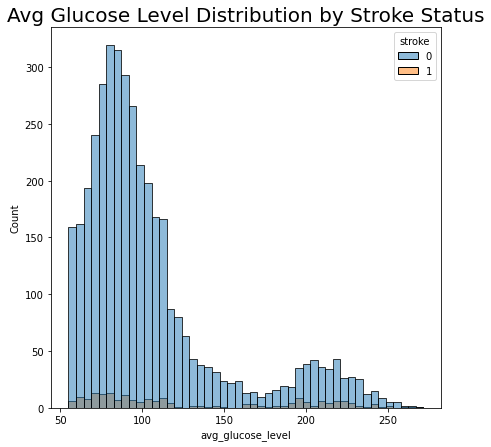

In [413]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=stroke_df, x="avg_glucose_level", hue="stroke", ax=ax)
plt.title("Avg Glucose Level Distribution by Stroke Status", size = def_title_size)

<class 'pandas._libs.interval.Interval'>


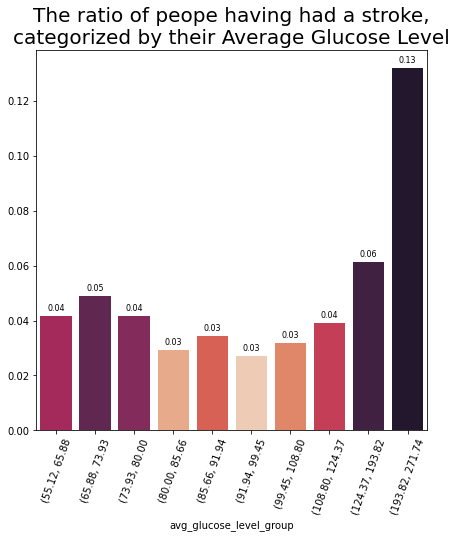

In [414]:
plot_continuous_variable_stroke_ratio(stroke_df, "avg_glucose_level", 10, "The ratio of peope having had a stroke,\ncategorized by their Average Glucose Level", 70)

As expected, both people with a very low and with a very high blood glucose level are more likely to have a stroke than the people with a regular glucose level. 

General medical guidelines state that a glucose level of less than 100mg/dL is normal after not eating for more than 8 hours, and a glucose level of less than 140mg/dL is normal after not eating for at least 2 hours ([see this analysis](https://https://www.webmd.com/diabetes/how-sugar-affects-diabetes)). These guidelines are confirmed by the above plot, which shows that


*   an average glucose level lower than 80mg/dL may increase the chance for a stroke, by ~30%
*   an average glucose level higher than 124mg/dL may dramatically increase the chance for a stroke, by more than 200%



#### Body Mass Index

There also might be children in our dataset, we do not want to consider them for the adult BMI analysis since the way their BMI is interpreted is different than for adults.

In [415]:
adults_only_df = stroke_df.loc[stroke_df['age']>=18]
adults_only_df.bmi.describe()

count    3259.000000
mean       30.480700
std         7.278777
min        11.300000
25%        25.500000
50%        29.300000
75%        34.200000
max        92.000000
Name: bmi, dtype: float64

A BMI of: 

* less than 18.5 is Underweight
* 18.5 - 25 is Normal	
* 25 - 30 is Overweight	
* 30 - 35 is Moderate Obesity
* 35 - 40 is Severe Obesity
* 40 - 46 is Very Severe Obesity
* 45-50 is Morbid
* 50-60 is Super
* greater then 60 is Hyper Obesity 
 
Data extracted from this ([article](https://www.topdoctors.co.uk/medical-dictionary/body-mass-index-bmi)).
 
 The fact that we have a mean value of 30 means that the dataset tends to describe a population that is slightly more overweight. 

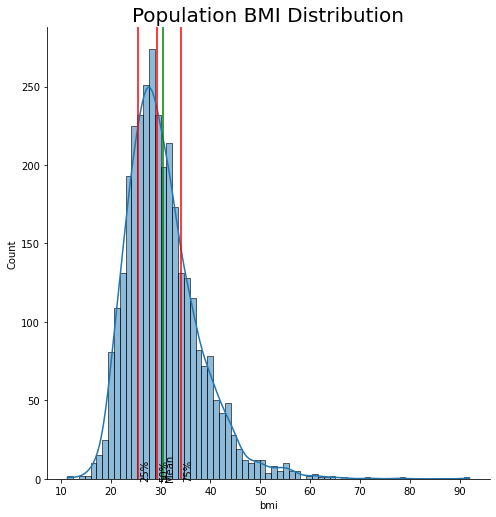

In [416]:
plot_continuous_variable_distribution(adults_only_df, adults_only_df.bmi, "bmi", "Population BMI Distribution")

The data from above might be better understood if we would classify the BMI value by what it represents i.e. underweight, normal, overweight etc.

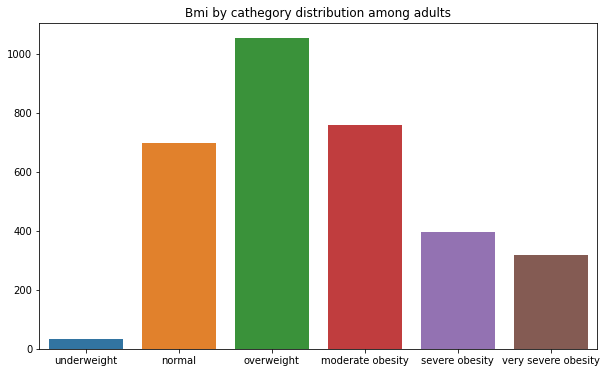

In [417]:
bmi_categ_list = ['underweight', 'normal', 'overweight',
              'moderate obesity', 'severe obesity', 'very severe obesity']
stroke_df_with_bmi_categ = adults_only_df.copy()
stroke_df_with_bmi_categ.bmi = pd.cut(stroke_df_with_bmi_categ.bmi,
                                      bins=[0, 18.5, 25, 30, 35, 40, 100],
                                      labels=bmi_categ_list)

bmi_categ_value_counts = stroke_df_with_bmi_categ.bmi.value_counts()

plt.figure(figsize=(10,6))
plt.title("Bmi by cathegory distribution among adults")
sns.barplot(x=bmi_categ_value_counts.index, y=bmi_categ_value_counts.array, order=bmi_categ_list)
plt.show()


The distrubution based on the BMI classifications is not very balanced, as is having more cases of overweight and obese people than people with normal weight. 

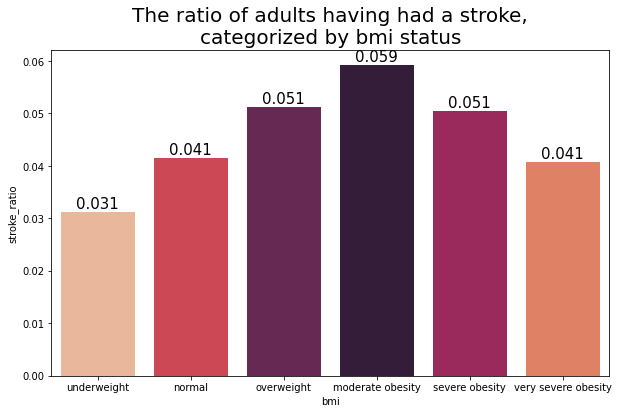

In [418]:
plot_categorical_variable_stroke_ratio(stroke_df_with_bmi_categ, "bmi", 
                                       "The ratio of adults having had a stroke,\ncategorized by bmi status",3)

The adults that are overweight or suffer from obesity are more likely to have a stroke. The plot also shows that a stroke is more common in our dataset among people that are overweight, than those that are suffering from obesity, but the difference is not big.

Now let's analyze how the BMI values for children.
 

In [419]:
children_only_df = stroke_df.loc[stroke_df['age']<18]
children_only_df.bmi.describe()

count    659.000000
mean      21.214719
std        6.351494
min       10.300000
25%       17.500000
50%       19.800000
75%       23.250000
max       97.600000
Name: bmi, dtype: float64

We can observe that the mean value for children is 21, which is less than the one for adults, as we should expect.

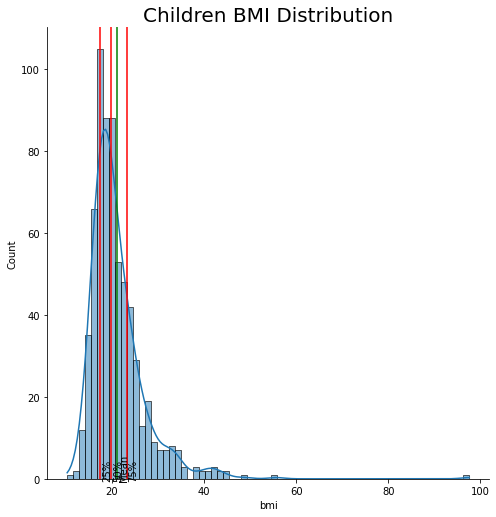

In [420]:
plot_continuous_variable_distribution(children_only_df, children_only_df.bmi, "bmi", "Children BMI Distribution")

As expected, the whole distribution of bmi for children lays to the left, having in general smaller values for bmi than the values that we have for adults.

<class 'pandas._libs.interval.Interval'>


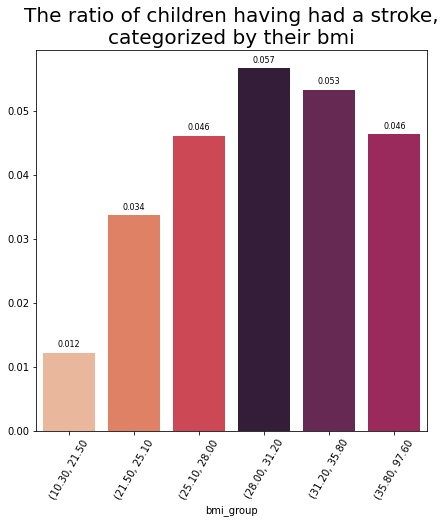

In [421]:
plot_continuous_variable_stroke_ratio(children_only_df, "bmi", 6, "The ratio of children having had a stroke,\ncategorized by their bmi", 60, 3)

#### Smoking Status

This feature shows whether a person


*   smokes
*   formerly smoked
*   never smoked
*   their smoking status is unknown



In [422]:
smoking_value_counts = stroke_df.smoking_status.value_counts()
smoking_value_counts

never smoked       1501
Unknown            1247
formerly smoked     714
smokes              626
Name: smoking_status, dtype: int64

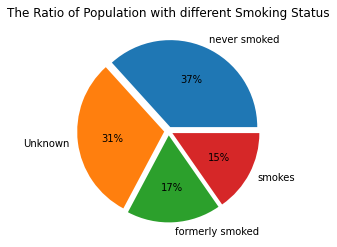

In [423]:
explode = [0.05] * smoking_value_counts.count()
plt.pie(smoking_value_counts.array, labels=smoking_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Ratio of Population with different Smoking Status")
plt.show()

We can see that 31% of the data is missing. We can't drop 30% of the data, so we should replace the 'Unknown' values somehow.

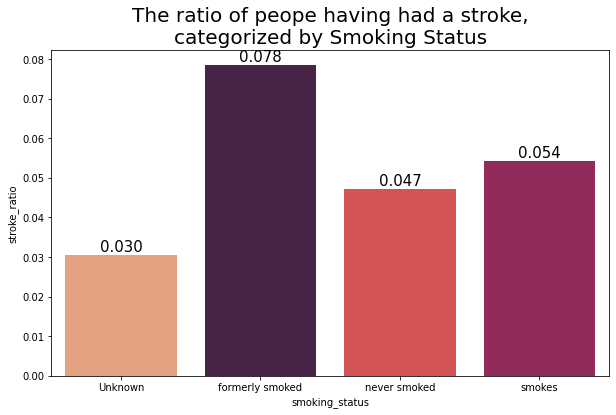

In [424]:
plot_categorical_variable_stroke_ratio(stroke_df, "smoking_status", "The ratio of peope having had a stroke,\ncategorized by Smoking Status", 3)

Unexpectedly, the ratio of people who had a stroke is higher among former smokers than among current smokers. 

This may be explained by the facts that:


*   those who have formerly smoked may be older
*   many of those who are smoking now may have smoked for less time




### The label: Stroke

The most imporant part is knowing the number of people that had stroke in our dataset, since this is what we are trying to predict.

In [425]:
stroke_value_counts = stroke_df.stroke.value_counts()
stroke_value_counts

0    3889
1     199
Name: stroke, dtype: int64

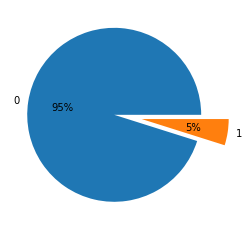

In [426]:
explode = [0.02,0.3]
plt.pie(stroke_value_counts.array, labels=stroke_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

Only 5% of people in our dataset have had a stroke. 

## Data Cleaning

Let's check where we have NaN values first.

In [427]:
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  170
smoking_status         0
stroke                 0
dtype: int64

The NaN values appear only for bmi, but it is not the only feature in our dataset that has to be cleaned.

### Gender

We have seen earlier that we have a single value in our dataset that has 'Other' as a gender, so it is better to remove it as it is not enough data to make predictions based on other genders.

In [428]:
stroke_df.drop(stroke_df[stroke_df['gender'] == 'Other'].index, inplace=True)
stroke_df.gender.value_counts()

Female    2395
Male      1692
Name: gender, dtype: int64

### Work Type

Fow work types, we have identified never_worked to have only 22 value counts. Some of the people that have never_worked as work type, are children. We should replace their work_status to children. To make things easier, we can directly delete the 5 rows for adults that have never_worked, and replace all remaing never_worked values with children.

In [429]:
stroke_df.drop(stroke_df[(stroke_df['work_type'] == 'Never_worked') & (stroke_df['age']>=18)].index, inplace=True)
print(stroke_df.work_type.value_counts())

Private          2331
Self-employed     667
children          554
Govt_job          522
Never_worked        9
Name: work_type, dtype: int64


In [430]:
stroke_df.work_type.replace("Never_worked", "children", inplace=True)
new_work_type_value_counts = stroke_df.work_type.value_counts()
new_work_type_value_counts

Private          2331
Self-employed     667
children          563
Govt_job          522
Name: work_type, dtype: int64

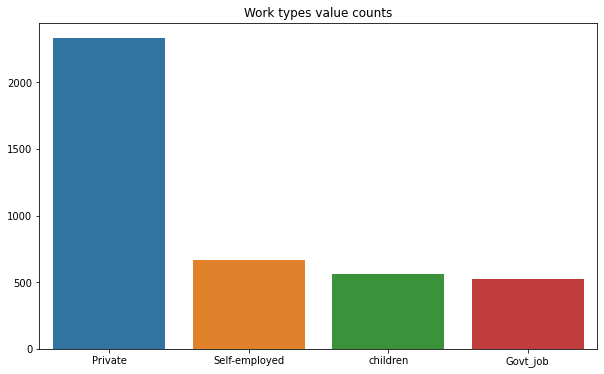

In [431]:
plt.figure(figsize=(10,6))
plt.title("Work types value counts")
sns.barplot(x=new_work_type_value_counts.index, y=new_work_type_value_counts.array)
plt.show()

### Body Mass Index

To replace the missing values there are several approaches:


*   Drop columns with missing value i.e. bmi
*   Use a simpleImputer with a median strategy to replace them
*   Replace with median based on age, as we expect a different bmi for adults then for children, also add a new column to tell which value was missing

To test which approach is better we will try to predict on the changed dataset for every approach, and measure which one give us a smaller mean abolute error.



In [432]:
bmi_stroke_df = stroke_df.copy()
y = bmi_stroke_df.stroke
X = bmi_stroke_df.drop(['stroke', 'id'], axis=1)
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown


In [433]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=0)

X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
3686,Female,80.0,1,0,Yes,Self-employed,Urban,218.00,33.5,Unknown
4582,Female,76.0,0,0,Yes,Govt_job,Urban,223.64,27.1,smokes
2590,Female,13.0,0,0,No,children,Urban,105.22,18.4,Unknown
2480,Male,14.0,0,0,No,children,Rural,112.22,26.9,Unknown
1534,Female,38.0,0,0,Yes,Private,Rural,196.20,32.8,never smoked


In [434]:
# handling categorical variables

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# apply one-hot encoder on them
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_transformed_train = OH_encoder.fit_transform(X_train[object_cols])
OH_transformed_valid = OH_encoder.transform(X_valid[object_cols])

column_names = OH_encoder.get_feature_names_out(object_cols)

OH_cols_train = pd.DataFrame(OH_transformed_train, columns=column_names)
OH_cols_valid = pd.DataFrame(OH_transformed_valid, columns=column_names)

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

#### *Approach 1*

Drop bmi column as it has missing values.

In [435]:
reduced_X_train = X_train.drop(['bmi'], axis=1)
reduced_X_valid = X_valid.drop(['bmi'], axis=1)

print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

0.09767441860465118


This is the mean absolute error that we got. Let's see if we can improve it.

#### *Approach 2*

We can replace the missing values with the median value, using a Simple Imputer.

In [436]:
simple_imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(simple_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(simple_imputer.transform(X_valid))

#imputer deleted the column names so we have to add them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

0.09302325581395349


The error is getting smaller.

#### *Approach 3*

A better aproach would be to replace with median according to age. Thus adults will get a median for adults, and children will have a median for children. We should also specify to the model that this was a missing value.

In [437]:
children_median, adults_median = get_mean_based_on_age(X_train)
X_train_plus = clean_bmi(X_train, children_median, adults_median)
X_valid_plus = clean_bmi(X_valid, children_median, adults_median)
print(score_dataset(X_train_plus, X_valid_plus, y_train, y_valid))

0.08935128518971848


It seems that the mean absolute error is now smaller. Altought it does not seem like a big improvement, it might be better this way for predicting on new data.

We will use approach 3 for our final cleaning for bmi.

In [438]:
children_median, adults_median = get_mean_based_on_age(stroke_df)
stroke_df = clean_bmi(stroke_df, children_median, adults_median )
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_was_missing
845,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0,False
3744,43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0,False
4183,47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0,False
3409,56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0,False
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0,False


In [439]:
stroke_df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
bmi_was_missing      0
dtype: int64

Indeed, we don't have null values anymore.

In [440]:
print("Median for adults")
print(adults_median)
print("Median for children")
print(children_median)

Median for adults
29.3
Median for children
19.8


We can observe that the median for adults is still much higher than what it is supposed to be a normal bmi, so they fall in the overweight category, almost close to moderate obesity.

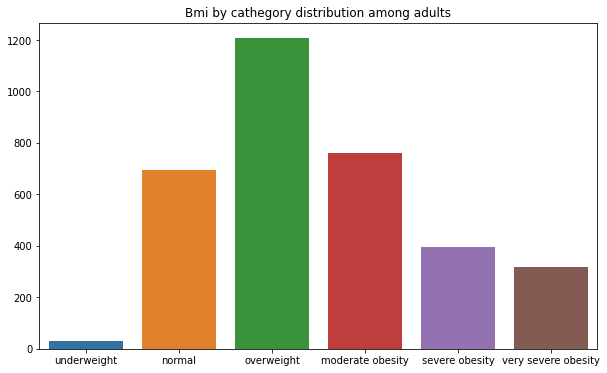

In [441]:
adults_only_df = stroke_df.loc[stroke_df['age']>=18]
new_stroke_df_with_bmi_categ = adults_only_df.copy()
new_stroke_df_with_bmi_categ.bmi = pd.cut(new_stroke_df_with_bmi_categ.bmi,
                                      bins=[0, 18.5, 25, 30, 35, 40, 100],
                                      labels=bmi_categ_list)

bmi_categ_value_counts = new_stroke_df_with_bmi_categ.bmi.value_counts()

plt.figure(figsize=(10,6))
plt.title("Bmi by cathegory distribution among adults")
sns.barplot(x=bmi_categ_value_counts.index, y=bmi_categ_value_counts.array, order=bmi_categ_list)
plt.show()

The overweight category has now more people, but also the ratio for overweight people that had a stroke has increased.

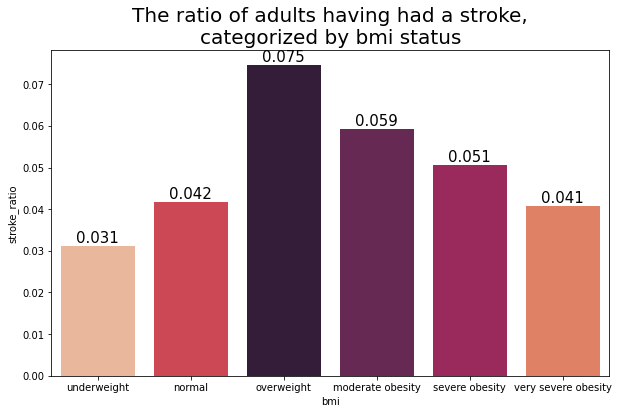

In [442]:
plot_categorical_variable_stroke_ratio(new_stroke_df_with_bmi_categ, "bmi", 
                                       "The ratio of adults having had a stroke,\ncategorized by bmi status",3)

### Smoking Status

##### The smoking status of children and teenagers




Other studies have shown that the earliest age when children start smoking is ~12 years old.

Resources:


*   [study on researchgate](https://www.researchgate.net/figure/Smoking-prevalence-by-gender-and-age-among-12-to-17-year-old-adolescents-in-Germany_fig2_251235344)
*   [CDC study](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/youth_data/tobacco_use/index.htm)
*   [statcan.gc.ca](https://www150.statcan.gc.ca/n1/pub/82-625-x/2020001/article/00003-eng.htm)



In [443]:
children_df = stroke_df[stroke_df.age < 18]
children_df.age = children_df.age.round()
children_age_smoking_categories = children_df.groupby(['age', 'smoking_status'])
children_age_smoking_categories_df = children_age_smoking_categories.size().reset_index(name='counts')
children_age_smoking_categories_df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,age,smoking_status,counts
0,0.0,Unknown,16
1,1.0,Unknown,49
2,2.0,Unknown,77
3,3.0,Unknown,39
4,4.0,Unknown,28
5,5.0,Unknown,52
6,6.0,Unknown,21
7,7.0,Unknown,24
8,8.0,Unknown,45
9,9.0,Unknown,33


Text(0.5, 1.0, 'The smoking status of underage people, by age group')

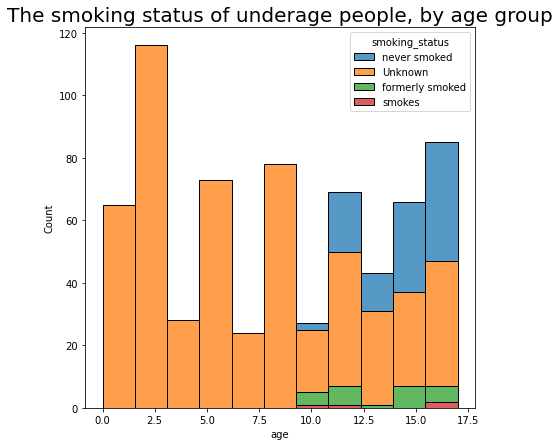

In [444]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=children_df, x="age", hue="smoking_status", ax=ax, multiple="stack")
plt.title("The smoking status of underage people, by age group", size = def_title_size)

The above table summarizes the number of childrean in each age + smoking_status group.

Observations:


*   all children below the age of 10 are reported with the status 'Unknown'. It seems safe to assume that these children in fact never smoked, so we cna replace their status with 'never smoked'
*   the youngest smokers that appear are 10 years old


In [445]:
# replace the smoking status of <10 years old children with 'never smoked'
stroke_df.smoking_status = np.where(np.logical_and(stroke_df.age < 10, stroke_df.smoking_status == 'Unknown'), "never smoked", stroke_df.smoking_status)

In [446]:
# New plots after the replacement
smoking_value_counts = stroke_df.smoking_status.value_counts()
smoking_value_counts

never smoked       1883
Unknown             861
formerly smoked     713
smokes              626
Name: smoking_status, dtype: int64

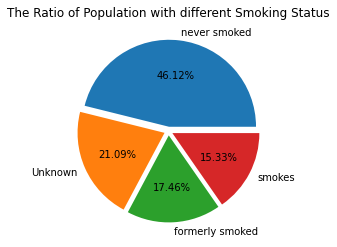

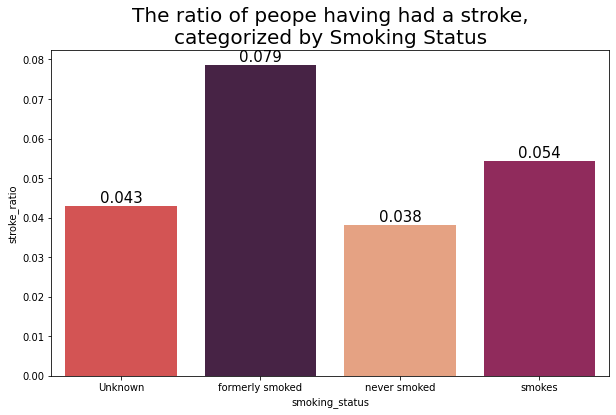

In [447]:
explode = [0.05] * smoking_value_counts.count()
plt.pie(smoking_value_counts.array, labels=smoking_value_counts.index, autopct = '%0.2f%%', explode = explode)
plt.title("The Ratio of Population with different Smoking Status")
plt.show()
plot_categorical_variable_stroke_ratio(stroke_df, "smoking_status", "The ratio of peope having had a stroke,\ncategorized by Smoking Status", 3)

##### Handling 'Unknown' values

Still, **21.09% of the entries have their smoking_status 'Unknown'**. We considered the following **options for replacing them**:


1.   replace with the most frequent value, i.e. 'never smoked'
2.   replace with a random value (possibly with the previous/next known value in the dataframe)
3.   build a model to predict the smoking_status of the entries with missing data

It is clear, that option 1 and 2 are "blind replacements". We discarded the idea of applying any of these to options because:


*   based on the above plot, showing the ratio of people who suffered a stroke in each smoking_status category, it seems like the smoking_status has a significant impact in the tendency to have a stroke
*   the entries with 'Unknown' smoking status represent >20%, a huge portion of the data, 

so replacing the 'Unknown' values with incorrect values may introduce a significant error in our future predictions.

So, let's try to build a cost-efficient, simple RandomForestClassifier for option 3 and see how well it works. If it works with a high f1 score, we can consider replacing the 'Unknwon' values with the predictions of the DecisionTreeClassifier. Otherwise, we should just work with 'Unknown' as a separate category.




In [448]:
smoke_df = stroke_df.copy()
smoke_df = smoke_df[smoke_df.smoking_status != 'Unknown']
X = smoke_df[smoke_df.columns.drop(['smoking_status', 'stroke', 'id'])].copy()
y = smoke_df.smoking_status
smoke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_was_missing
845,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0,False
3744,43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0,False
4183,47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0,False
3409,56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0,False
4796,67159,Male,73.0,1,0,No,Govt_job,Urban,71.29,37.7,never smoked,0,False


In [449]:
X_train, X_valid, y_train, y__valid = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [450]:
# handling categorical variables

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# apply one-hot encoder on them
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_transformed_train = OH_encoder.fit_transform(X_train[object_cols])
OH_transformed_valid = OH_encoder.transform(X_valid[object_cols])

column_names = OH_encoder.get_feature_names_out(object_cols)

OH_cols_train = pd.DataFrame(OH_transformed_train, columns=column_names)
OH_cols_valid = pd.DataFrame(OH_transformed_valid, columns=column_names)

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [451]:
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,bmi_was_missing,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban
2062,15.00,0,0,121.60,22.8,False,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2487,78.00,0,0,126.39,21.3,False,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1944,70.00,0,0,62.67,27.7,False,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
592,56.00,0,0,100.83,26.8,False,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1878,63.00,0,0,104.70,21.0,False,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006,1.64,0,0,90.74,19.9,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3901,46.00,0,0,159.67,37.3,False,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3274,79.00,0,0,57.77,24.1,False,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
21,52.00,1,0,233.29,48.9,False,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [452]:
for complexity in range(5,156,30):
  print("-------------------------------------------- Tree with max leav nodes = ", complexity)
  dt_classifier = RandomForestClassifier(criterion = "entropy", max_leaf_nodes = complexity)
  dt_classifier.fit(X_train, y_train)
  print("Accuracy: ", dt_classifier.score(X_test, y_test))
  y_test_pred = dt_classifier.predict(X_test)
  print(classification_report(y_test, y_test_pred))

-------------------------------------------- Tree with max leav nodes =  5
Accuracy:  0.5955334987593052
                 precision    recall  f1-score   support

formerly smoked       0.00      0.00      0.00       182
   never smoked       0.60      1.00      0.75       480
         smokes       0.00      0.00      0.00       144

       accuracy                           0.60       806
      macro avg       0.20      0.33      0.25       806
   weighted avg       0.35      0.60      0.44       806

-------------------------------------------- Tree with max leav nodes =  35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.6029776674937966
                 precision    recall  f1-score   support

formerly smoked       0.43      0.05      0.09       182
   never smoked       0.61      0.98      0.75       480
         smokes       0.60      0.04      0.08       144

       accuracy                           0.60       806
      macro avg       0.55      0.36      0.31       806
   weighted avg       0.57      0.60      0.48       806

-------------------------------------------- Tree with max leav nodes =  65
Accuracy:  0.6017369727047146
                 precision    recall  f1-score   support

formerly smoked       0.42      0.06      0.11       182
   never smoked       0.61      0.97      0.75       480
         smokes       0.60      0.04      0.08       144

       accuracy                           0.60       806
      macro avg       0.54      0.36      0.31       806
   weighted avg       0.56      0.60      0.48       806

-------------------------------------------- Tree with max l

As we can see, the weighted F1-score barely reaches 0.5, so a simple RandomForestClassifier is not enough to accurately predict the smoking status of people. 

This is not a surprising finding actually: other than age, no feature allows us to make an assumption about the lifestyle of each person in the dataset, and we have already exploited the fact that small children are most probably non-smokers.

This makes it useless to try more complex and computationally more expensive ML models for predicting the smoking status of people.

**As a final conclusion, the 'Unknown' values will be treated as a 4. smoking_status category in the analysis.**

### ID

Last but not least, we should drop the id column as we dont need it.

In [453]:
stroke_df.drop(['id'], axis=1, inplace=True)
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_was_missing
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0,False
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0,False
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0,False
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0,False
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0,False


This is the final dataset that we achived after performing data cleaning.



## Random code

TODO: delete this section

In [454]:
stroke_df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
bmi_was_missing      0
dtype: int64

In [455]:
stroke_df.work_type.value_counts()

Private          2331
Self-employed     667
children          563
Govt_job          522
Name: work_type, dtype: int64

In [456]:
stroke_df.age.map(lambda a: 1 if a >= 16 else 0).value_counts()

1    3494
0     589
Name: age, dtype: int64

In [457]:
stroke_df[stroke_df["age"]<16][stroke_df["work_type"]!="children"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_was_missing
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0,False
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0,False
2485,Female,14.0,0,0,No,Private,Rural,70.54,24.4,formerly smoked,0,False
2455,Female,14.0,0,0,No,Private,Rural,233.71,22.9,never smoked,0,False
3334,Male,13.0,0,0,No,Private,Rural,90.60,16.9,never smoked,0,False
3749,Female,14.0,0,0,No,Self-employed,Rural,77.52,21.9,never smoked,0,False
4572,Male,15.0,0,0,No,Private,Urban,104.90,27.4,never smoked,0,False
2411,Male,14.0,0,0,No,Private,Urban,79.36,48.8,never smoked,0,False
2794,Male,14.0,0,0,No,Private,Rural,108.65,23.1,never smoked,0,False
950,Male,15.0,0,0,No,Private,Urban,57.94,41.7,Unknown,0,False
